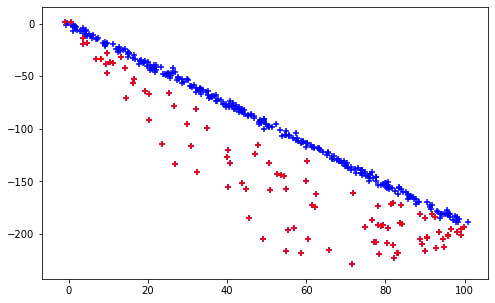

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
np.warnings.filterwarnings('ignore')

n_samples = 400
input_dim = 1
output_dim = 1

# generate perfect input data
A_exact = 100*np.random.random((n_samples,input_dim))
perfect_fit = np.random.normal(size=(input_dim,output_dim))
B_exact = scipy.dot(A_exact,perfect_fit)

# add small noise
A_noisy = A_exact + np.random.normal(size=A_exact.shape )
B_noisy = B_exact + np.random.normal(size=B_exact.shape )

# add some outliers
n_outliers = 100
dd = np.random.rand(n_outliers,input_dim)+0.2
C_noisy = B_noisy.mean()*dd*np.sin(0.03*A_noisy[0:n_outliers])
B_noisy[0:n_outliers] += C_noisy

plt.figure(figsize=[8,5])
plt.scatter(A_noisy, B_noisy, c='b', marker='+')
plt.scatter(A_noisy[0:n_outliers], B_noisy[0:n_outliers], c='r', marker='+');

perfect fit = 0.7904
LLS fit = 0.8578


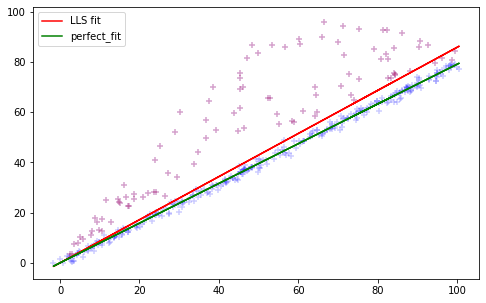

In [10]:
class LinearLeastSquaresModel:

    def __init__(self):
        pass
    def fit(self, data):
        A = data[:,0,None]
        B = data[:,1,None]
        x, _, _, _ = np.linalg.lstsq(A, B)
        return x
    def get_error(self, model, data):
        A = data[:,0,None]
        B = data[:,1,None]
        B_fit = np.dot(A, model)
        err_per_point = np.sum((B-B_fit)**2,axis=1)
        return err_per_point

data = np.hstack((A_noisy, B_noisy))
model = LinearLeastSquaresModel()
x = model.fit(data)
print("perfect fit = {:.4f}\nLLS fit = {:.4f}".format(perfect_fit[0][0], x[0][0]))

plt.figure(figsize=[8,5])
plt.scatter(A_noisy, B_noisy, c='b', marker='+', alpha=0.2)
plt.scatter(A_noisy[0:n_outliers], B_noisy[0:n_outliers], c='r', marker='+', alpha=0.2)
plt.plot(A_noisy, A_noisy.dot(x), c='r', label='LLS fit')
plt.plot(A_noisy, A_noisy.dot(perfect_fit), c='g', label='perfect_fit')
plt.legend();

In [3]:
def ransac(data,model,n,k,t,d,debug=False,return_all=False):

    def random_partition(n, n_data):
        all_index = np.arange(n_data)
        idx1 = np.random.choice(all_index, n, replace=False)
        idx2 = np.setdiff1d(all_index, idx1)
        return idx1, idx2

    iterations = 0
    bestfit = None
    besterr = np.inf
    best_inlier_idxs = None
    while iterations < k:
        maybe_idxs, test_idxs = random_partition(n,data.shape[0])
        maybeinliers = data[maybe_idxs,:]
        test_points = data[test_idxs]
        maybemodel = model.fit(maybeinliers)
        test_err = model.get_error(maybemodel, test_points)
        also_idxs = test_idxs[test_err < t] # select indices of rows with accepted points
        alsoinliers = data[also_idxs,:]
        if debug:
            print('test_err.min()',test_err.min())
            print('test_err.max()',test_err.max())
            print('np.mean(test_err)',np.mean(test_err))
            print('iteration {}:len(alsoinliers) = {}'.format(iterations,len(alsoinliers)))
        if len(alsoinliers) > d:
            betterdata = np.concatenate( (maybeinliers, alsoinliers) )
            bettermodel = model.fit(betterdata)
            better_errs = model.get_error(bettermodel, betterdata)
            thiserr = np.mean( better_errs )
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
                best_inlier_idxs = np.concatenate( (maybe_idxs, also_idxs) )
        iterations+=1
    if bestfit is None:
        raise ValueError("did not meet fit acceptance criteria")
    if return_all:
        return bestfit, {'inliers':best_inlier_idxs}
    else:
        return bestfit

Given:
    data - a set of observed data points
    model - a model that can be fitted to data points
    n - the minimum number of data values required to fit the model
    k - the maximum number of iterations allowed in the algorithm
    t - a threshold value for determining when a data point fits a model
    d - the number of close data values required to assert that a model fits well to data
Return:
    bestfit - model parameters which best fit the data (or nil if no good model is found)

iterations = 0
bestfit = nil
besterr = something really large
while iterations < k {
    maybeinliers = n randomly selected values from data
    maybemodel = model parameters fitted to maybeinliers
    alsoinliers = empty set
    for every point in data not in maybeinliers {
        if point fits maybemodel with an error smaller than t
             add point to alsoinliers
    }
    if the number of elements in alsoinliers is > d {
        % this implies that we may have found a good model
        % now test how good it is
        bettermodel = model parameters fitted to all points in maybeinliers and alsoinliers
        thiserr = a measure of how well model fits these points
        if thiserr < besterr {
            bestfit = bettermodel
            besterr = thiserr
        }
    }
    increment iterations
}
return bestfit

perfect fit = 0.7904
LLS fit = 0.8578
RANSAC fit = 0.7938


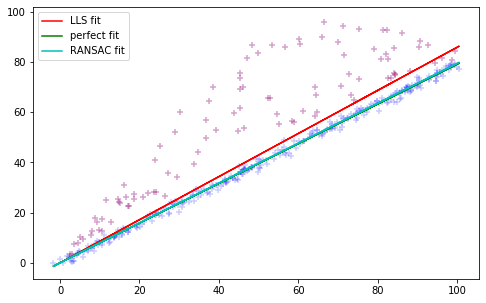

In [4]:
model = LinearLeastSquaresModel()
ransac_fit = ransac(data, model, n=50, k=300, t=30, d=200)

print("perfect fit = {:.4f}\nLLS fit = {:.4f}\nRANSAC fit = {:.4f}"
      .format(perfect_fit[0,0], x[0,0], ransac_fit[0,0]))

plt.figure(figsize=[8,5])
plt.scatter(A_noisy, B_noisy, c='b', marker='+', alpha=0.2)
plt.scatter(A_noisy[0:n_outliers], B_noisy[0:n_outliers], c='r', marker='+', alpha=0.2)
plt.plot(A_noisy, A_noisy.dot(x), c='r', label='LLS fit')
plt.plot(A_noisy, A_noisy.dot(perfect_fit), c='g', label='perfect fit')
plt.plot(A_noisy, A_noisy.dot(ransac_fit), c='c', label='RANSAC fit')
plt.legend();

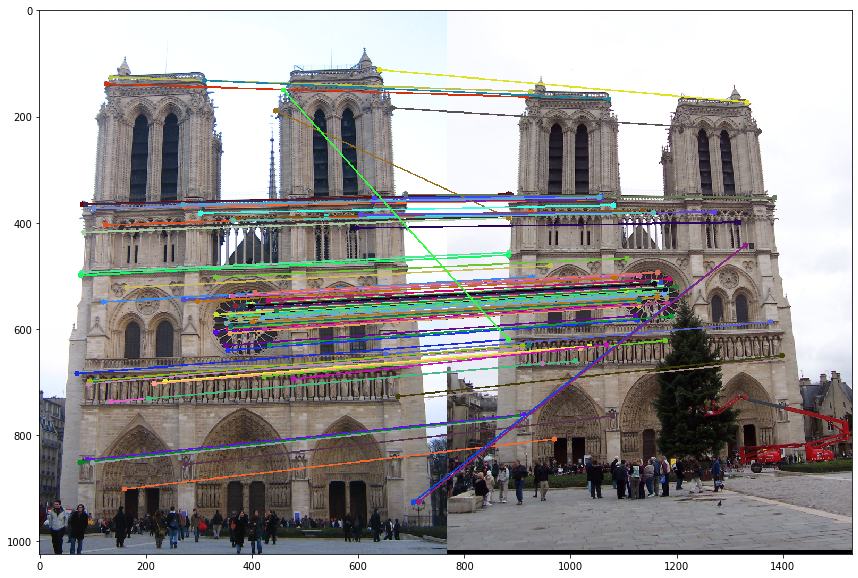

In [8]:
import cv2
import ransac
from utils import *
import matplotlib.pyplot as plt

image1 = load_image('data/921919841_a30df938f2_o.jpg')
image2 = load_image('data/4191453057_c86028ce1f_o.jpg')
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)

data = np.load('./data/match_points.npz')
x1 = data['x1']
y1 = data['y1']
x2 = data['x2']
y2 = data['y2']

c1 = show_correspondence_lines(image1, image2, x1, y1, x2, y2)
plt.figure(figsize=[15,10])
plt.imshow(c1);

In [6]:
class Fundamental(object):
    def __init__(self,debug=False):
        self.debug = debug

    def compute_fundamental(self,x1,x2):
        """    Computes the fundamental matrix from corresponding points 
            (x1,x2 3*n arrays) using the 8 point algorithm.
            Each row in the A matrix below is constructed as
            [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] """
        
        n = x1.shape[1]
        if x2.shape[1] != n:
            raise ValueError("Number of points don't match.")
        A = np.zeros((n,9))
        for i in range(n):
            A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                    x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                    x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
        U,S,V = np.linalg.svd(A)
        F = V[-1].reshape(3,3)
        U,S,V = np.linalg.svd(F)
        S[2] = 0
        F = np.dot(U,np.dot(np.diag(S),V))
        return F/F[2,2]

    def compute_fundamental_normalized(self,x1,x2):
        n = x1.shape[1]
        if x2.shape[1] != n:
            raise ValueError("Number of points don't match.")
        x1 = x1 / x1[2]
        mean_1 = np.mean(x1[:2],axis=1)
        S1 = np.sqrt(2) / np.std(x1[:2])
        T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
        x1 = np.dot(T1,x1)
        x2 = x2 / x2[2]
        mean_2 = np.mean(x2[:2],axis=1)
        S2 = np.sqrt(2) / np.std(x2[:2])
        T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
        x2 = np.dot(T2,x2)
        F = self.compute_fundamental(x1,x2)
        F = np.dot(T1.T,np.dot(F,T2))
        return F/F[2,2]
    
    def fit(self,data):
        data = data.T
        x1 = data[:3,:8]
        x2 = data[3:,:8]
        F = self.compute_fundamental_normalized(x1,x2)
        return F
    
    def get_error(self,data,F):
        data = data.T
        x1 = data[:3]
        x2 = data[3:]
        Fx1 = np.dot(F,x1)
        Fx2 = np.dot(F,x2)
        denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
        err = (np.diag(np.dot(x1.T,np.dot(F,x2))) )**2 / denom 
        return err


In [11]:
A = np.hstack((x1[:,None], y1[:,None], np.ones_like(x1[:,None]))).T
B = np.hstack((x2[:,None], y2[:,None], np.ones_like(x2[:,None]))).T
data = np.vstack((A,B))#6*100
model = Fundamental()

F,ransac_data = ransac.ransac(data.T,model,8,300,30,80,return_all=True)
idx = ransac_data['inliers']
xx1 = x1[idx]
yy1 = y1[idx]
xx2 = x2[idx]
yy2 = y2[idx]
 
c2 = show_correspondence_lines(image1, image2, xx1, yy1, xx2, yy2)
plt.figure(figsize=[15,10])
plt.imshow(c2);

KeyboardInterrupt: 